CSV de exemplo criado com informações de pacientes de Canela (RS).
CSV limpo salvo em: output/cleaned_dataset_canela.csv

=== Análise Exploratória - Pacientes de Canela (RS) ===
Shape: (200, 18)

Valores faltantes por coluna:
idade                 0
sexo                  0
tabagismo             0
pack_years            0
tosse                 0
hemoptise             0
perda_peso            0
peso                  0
altura                0
saturacao_oxigenio    0
massa_nodulo_mm       0
ocupacao_risco        0
exposicao_amianto     0
diagnostico_cancer    0
cidade                0
altura_m              0
imc                   0
imc_valido            0
dtype: int64
Estatísticas descritivas salvas em CSV.
tabela de contagem 'sexo' salva em CSV.
tabela de contagem 'tabagismo' salva em CSV.
tabela de contagem 'tosse' salva em CSV.
tabela de contagem 'hemoptise' salva em CSV.
tabela de contagem 'perda_peso' salva em CSV.
tabela de contagem 'ocupacao_risco' salva em CSV.
tabela de contagem 'ex

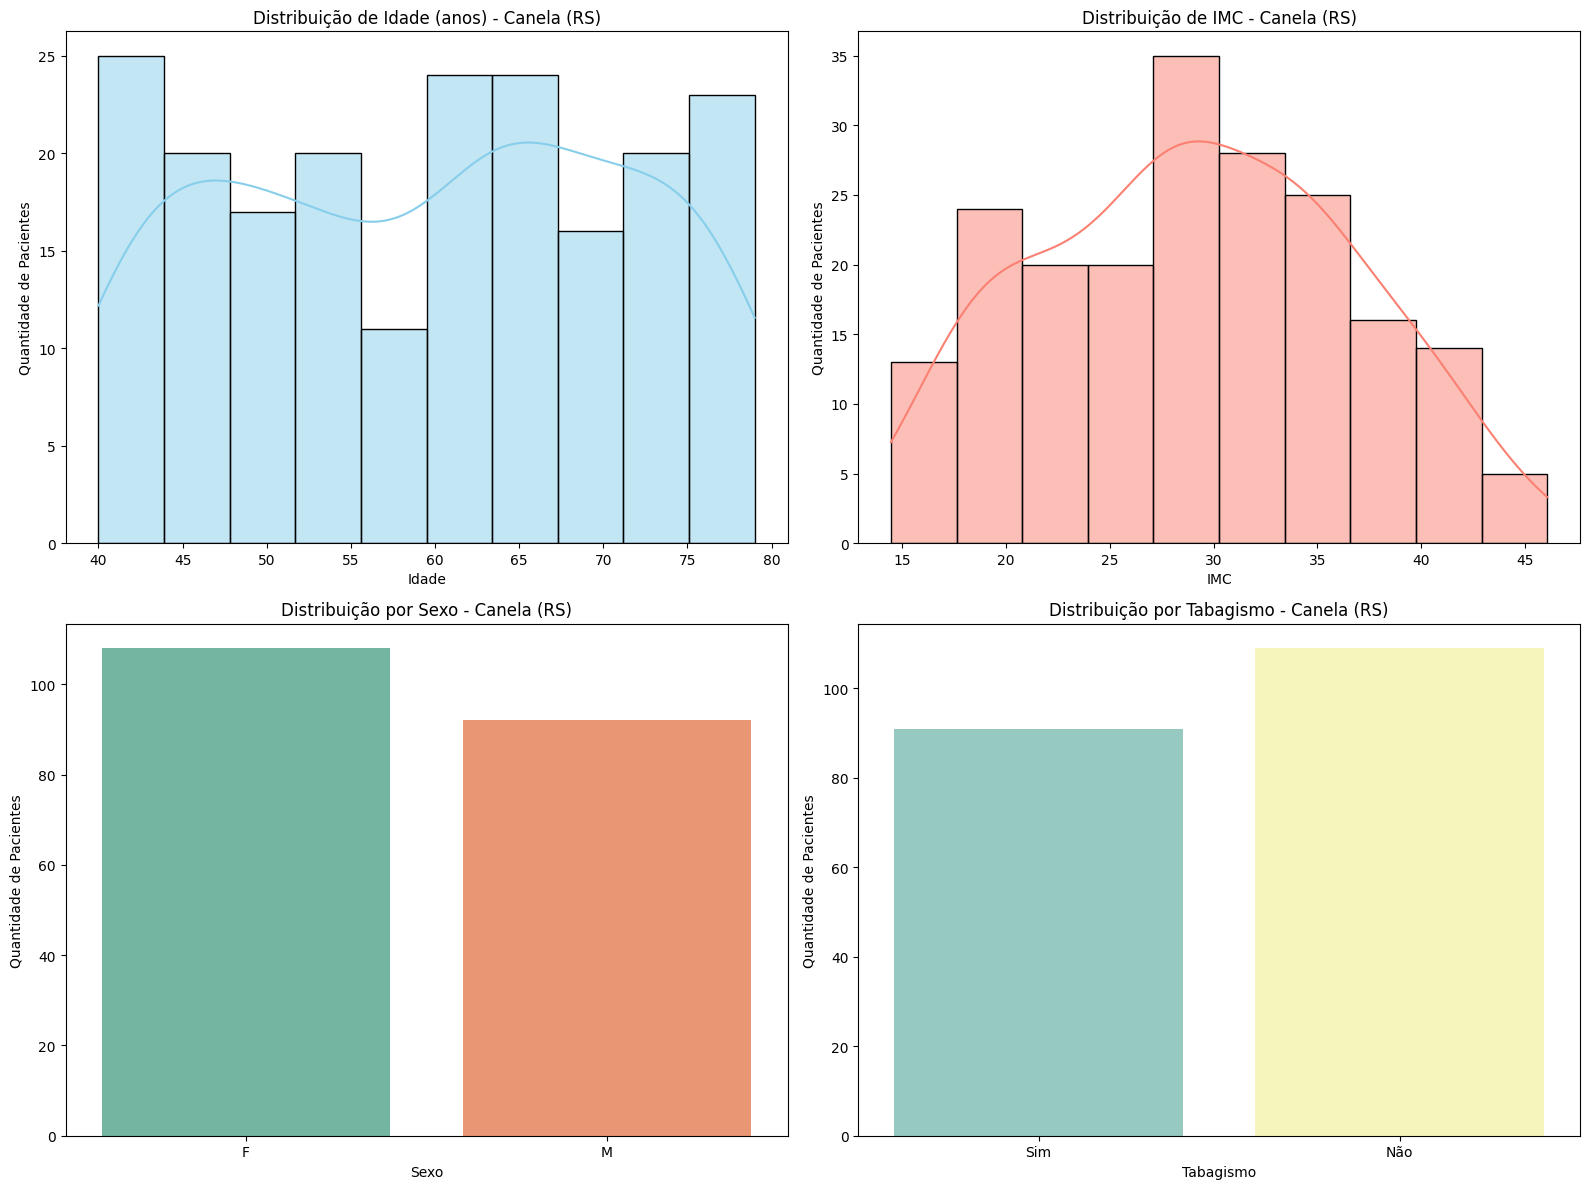

EDA gráfico salvo em PNG.
Métricas de classificação salvas em CSV.
Matriz de confusão salva em CSV.


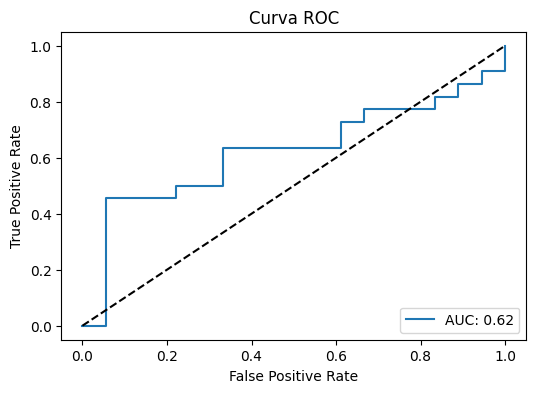

Curva ROC salva em PNG.


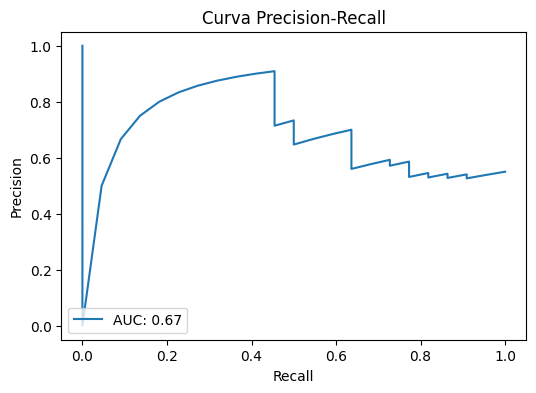

Curva Precision-Recall salva em PNG.


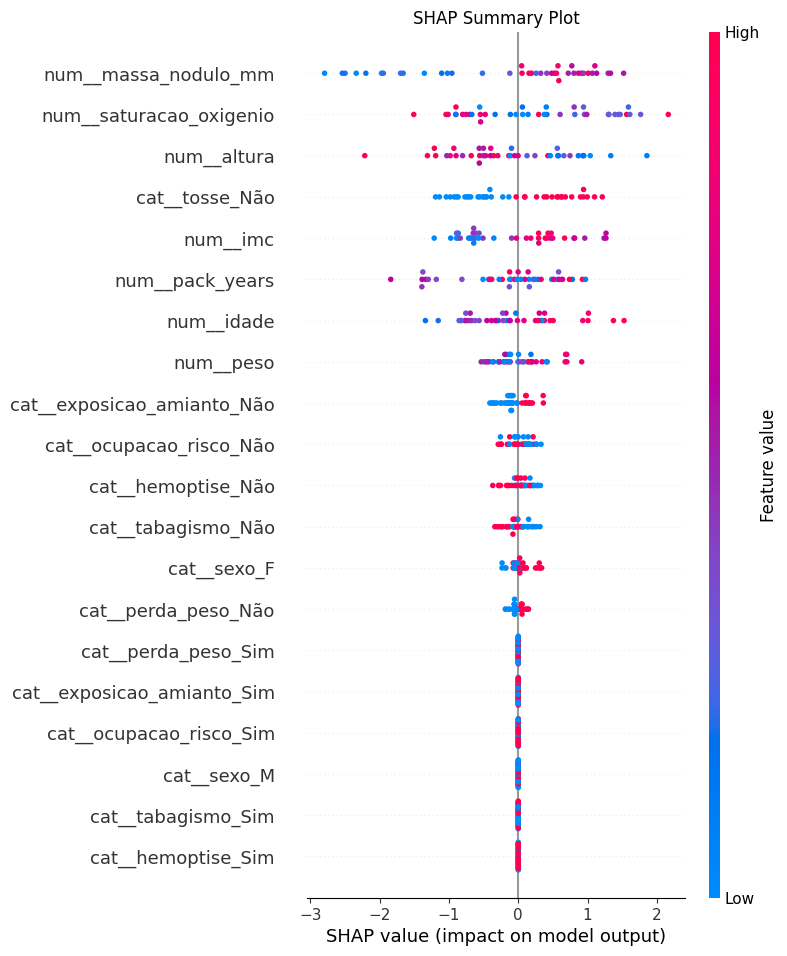

SHAP summary plot salvo em PNG.
Modelo salvo em: output/model.pkl
Predições salvas em: output/predictions.csv

Pipeline de análise e modelagem para pacientes de Canela (RS) concluído.


In [10]:
#utilizei o meu nome( na parte de médico )
#mudei para a cidade que eu Cresci(Canela-RS)

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, precision_recall_curve, auc

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import joblib
import shap

OUTPUT_DIR = Path("./output")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
CLEANED_PATH = OUTPUT_DIR / "cleaned_dataset_canela.csv"
np.random.seed(42)
n = 200
df = pd.DataFrame({
    "idade": np.random.randint(40, 80, size=n),
    "sexo": np.random.choice(["M", "F"], size=n),
    "tabagismo": np.random.choice(["Sim", "Não"], size=n),
    "tosse": np.random.choice(["Sim", "Não"], size=n),
    "hemoptise": np.random.choice(["Sim", "Não"], size=n),
    "perda_peso": np.random.choice(["Sim", "Não"], size=n),
    "peso": np.random.randint(50, 120, size=n),
    "altura": np.random.randint(150, 190, size=n),
    "saturacao_oxigenio": np.random.randint(85, 100, size=n),
    "ocupacao_risco": np.random.choice(["Sim", "Não"], size=n),
    "exposicao_radiação": np.random.choice(["Sim", "Não"], size=n),
    "diagnostico_cancer": np.random.choice([0,1], size=n),
    "cidade": ["Canela (RS)"]*n
})
df.to_csv("dados_canela.csv", index=False)
print("informações de pacientes de Canela (RS).")

#
def standardize_sexo(s):
    if pd.isna(s):
        return "O"
    s = str(s).strip().lower()
    if s in ["m","masculino","male","homem","h"]:
        return "M"
    if s in ["f","feminino","female","mulher","fem"]:
        return "F"
    return "O"
def load_and_clean_csv(path):
    df = pd.read_csv(path)
    for col in ["saturacao_oxigenio","peso","altura"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(df[col].median())
    if "sexo" in df.columns:
        df["sexo"] = df["sexo"].apply(standardize_sexo)
    if ("peso" in df.columns) and ("altura" in df.columns):
        df["altura_m"] = df["altura"].apply(lambda x: x/100 if x>3 else x)
        df["imc"] = df["peso"] / (df["altura_m"] ** 2)
        df["imc_valido"] = df["imc"].apply(lambda x: True if 10 <= x <= 70 else False)
    df.to_csv(CLEANED_PATH, index=False)
    print("CSV limpo salvo em:", CLEANED_PATH)
    return df
def eda(df):
    print("\n=== Análise Exploratória - Pacientes de Canela (RS) ===")
    print("Shape:", df.shape)
    print("\nValores faltantes por coluna:")
    print(df.isnull().sum())
    desc = df.describe(include='all').transpose()
    desc.to_csv(OUTPUT_DIR / "estatisticas_descritivas.csv")

    for col in ["sexo","tabagismo","tosse","hemoptise","perda_peso","ocupacao_risco","exposicao_amianto"]:
        contagem = df[col].value_counts().reset_index()
        contagem.columns = [col, "Quantidade"]
        contagem.to_csv(OUTPUT_DIR / f"tabela_contagem_{col}.csv", index=False)
        print(f"tabela de contagem '{col}' salva em CSV.")

    plt.figure(figsize=(16,12))
    plt.subplot(2,2,1)
    sns.histplot(df["idade"], bins=10, kde=True, color='skyblue')
    plt.title("Distribuição de Idade (anos) - Canela (RS)")
    plt.xlabel("Idade")
    plt.ylabel("Quantidade de Pacientes")
    plt.subplot(2,2,2)
    sns.histplot(df["imc"], bins=10, kde=True, color='salmon')
    plt.title("Distribuição de IMC - Canela (RS)")
    plt.xlabel("IMC")
    plt.ylabel("Quantidade de Pacientes")
    plt.subplot(2,2,3)
    sns.countplot(x="sexo", data=df, palette="Set2")
    plt.title("Distribuição por Sexo - Canela (RS)")
    plt.xlabel("Sexo")
    plt.ylabel("Quantidade de Pacientes")
    plt.subplot(2,2,4)
    sns.countplot(x="tabagismo", data=df, palette="Set3")
    plt.title("Distribuição por Tabagismo - Canela (RS)")
    plt.xlabel("Tabagismo")
    plt.ylabel("Quantidade de Pacientes")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "eda_canela.png")
    plt.show()

def train_model(df):
    target = "diagnostico_cancer"
    features = ["idade","sexo","tabagismo","pack_years","tosse","hemoptise","perda_peso",
                "peso","altura","imc","saturacao_oxigenio","massa_nodulo_mm","ocupacao_risco","exposicao_amianto"]
    X = df[features]
    y = df[target].astype(int)
    numeric_feats = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_feats = [c for c in X.columns if c not in numeric_feats]
    preprocessor = ColumnTransformer([
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")),("scaler", StandardScaler())]), numeric_feats),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),("onehot", OneHotEncoder(handle_unknown="ignore"))]), categorical_feats)
    ])

    clf = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
    pipeline = ImbPipeline([("preproc", preprocessor), ("smote", SMOTE(random_state=42)), ("clf", clf)])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:,1]
    report = classification_report(y_test, y_pred, output_dict=True)
    pd.DataFrame(report).transpose().to_csv(OUTPUT_DIR / "metricas_classificacao.csv")
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=["Negativo","Positivo"], columns=["Negativo","Positivo"])
    cm.to_csv(OUTPUT_DIR / "matriz_confusao.csv")
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'AUC: {roc_auc_score(y_test, y_prob):.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC")
    plt.legend(loc="lower right")
    plt.savefig(OUTPUT_DIR / "curva_roc.png")
    plt.show()
    print("Curva ROC salva em PNG.")
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, label=f'AUC: {auc(recall, precision):.2f}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Curva Precision-Recall")
    plt.legend(loc="lower left")
    plt.savefig(OUTPUT_DIR / "curva_precision_recall.png")
    plt.show()
    print("Curva Precision-Recall salva em PNG.")
    explainer = shap.TreeExplainer(pipeline.named_steps["clf"])
    shap_values = explainer.shap_values(preprocessor.transform(X_test))

    if isinstance(shap_values, list):
        shap_values_to_plot = shap_values[1]
    else:

        shap_values_to_plot = shap_values

    shap.summary_plot(shap_values_to_plot, preprocessor.transform(X_test), feature_names=preprocessor.get_feature_names_out(), show=False)
    plt.title("SHAP Summary Plot")
    plt.savefig(OUTPUT_DIR / "shap_summary_plot.png", bbox_inches='tight')
    plt.show()
    print("SHAP summary plot salvo em PNG.")
    joblib.dump(pipeline, OUTPUT_DIR / "model.pkl")
    print("Modelo salvo em:", OUTPUT_DIR / "model.pkl")

    return pipeline
def predict(model, df):
    X = df[["idade","sexo","tabagismo","pack_years","tosse","hemoptise","perda_peso",
            "peso","altura","imc","saturacao_oxigenio","massa_nodulo_mm","ocupacao_risco","exposicao_amianto"]]
    predictions = model.predict(X)
    df["predicted_diagnostico_cancer"] = predictions
    df.to_csv(OUTPUT_DIR / "predictions.csv", index=False)
    print("Predições salvas em:", OUTPUT_DIR / "predictions.csv")
    return df
df_canela = load_and_clean_csv("dados_canela.csv")

eda(df_canela)

trained_model = train_model(df_canela)

df_canela_predicted = predict(trained_model, df_canela)

print("\nPipeline de análise e modelagem para pacientes de Canela (RS) concluído.")